In [72]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.data import Dataset

In [12]:
train_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Train_Alphabet'
test_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Test_Alphabet'

In [19]:
train_path = train_path
test_path = test_path
for d in [train_path, test_path]:
    filepaths = []
    labels=[]
    classlist=sorted(os.listdir(d))
    for klass in classlist:        
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_path:            
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels']) 
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  19440   test_df length:  2400   valid_df length:  2160
The number of classes in the dataset is:  24
            CLASS               IMAGE COUNT 
              A                     810     
              B                     810     
              C                     810     
              D                     810     
              E                     810     
              F                     810     
              G                     810     
              H                     810     
              I                     810     
              K                     810     
              L                     810     
              M                     810     
              N                     810     
              O                     810     
              P                     810     
              Q                     810     
              R                     810     
              S                     810     
              T            

In [20]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

In [21]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize = (20, 20))
    length = len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [22]:
max_samples=150 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=150
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  150  and the minimum samples in any class is  150


In [123]:
working_dir=r'./'
img_size = (128, 128)
batch_size = 30

trgen = ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                            height_shift_range=.2, zoom_range=.2)
t_and_v_gen = ImageDataGenerator()

msg = '{0:70s} for train generator'.format(' ')
print(msg, '\r', end = '') # prints over on the same line

train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

msg = '{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps = int(length/test_batch_size)

msg = '{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# from the generator we can get information we will need later
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3600 validated image filenames belonging to 24 classes.          for train generator 
Found 2160 validated image filenames belonging to 24 classes.          for valid generator 
Found 2400 validated image filenames belonging to 24 classes.          for test generator 
test batch size:  80   test steps:  30  number of classes :  24


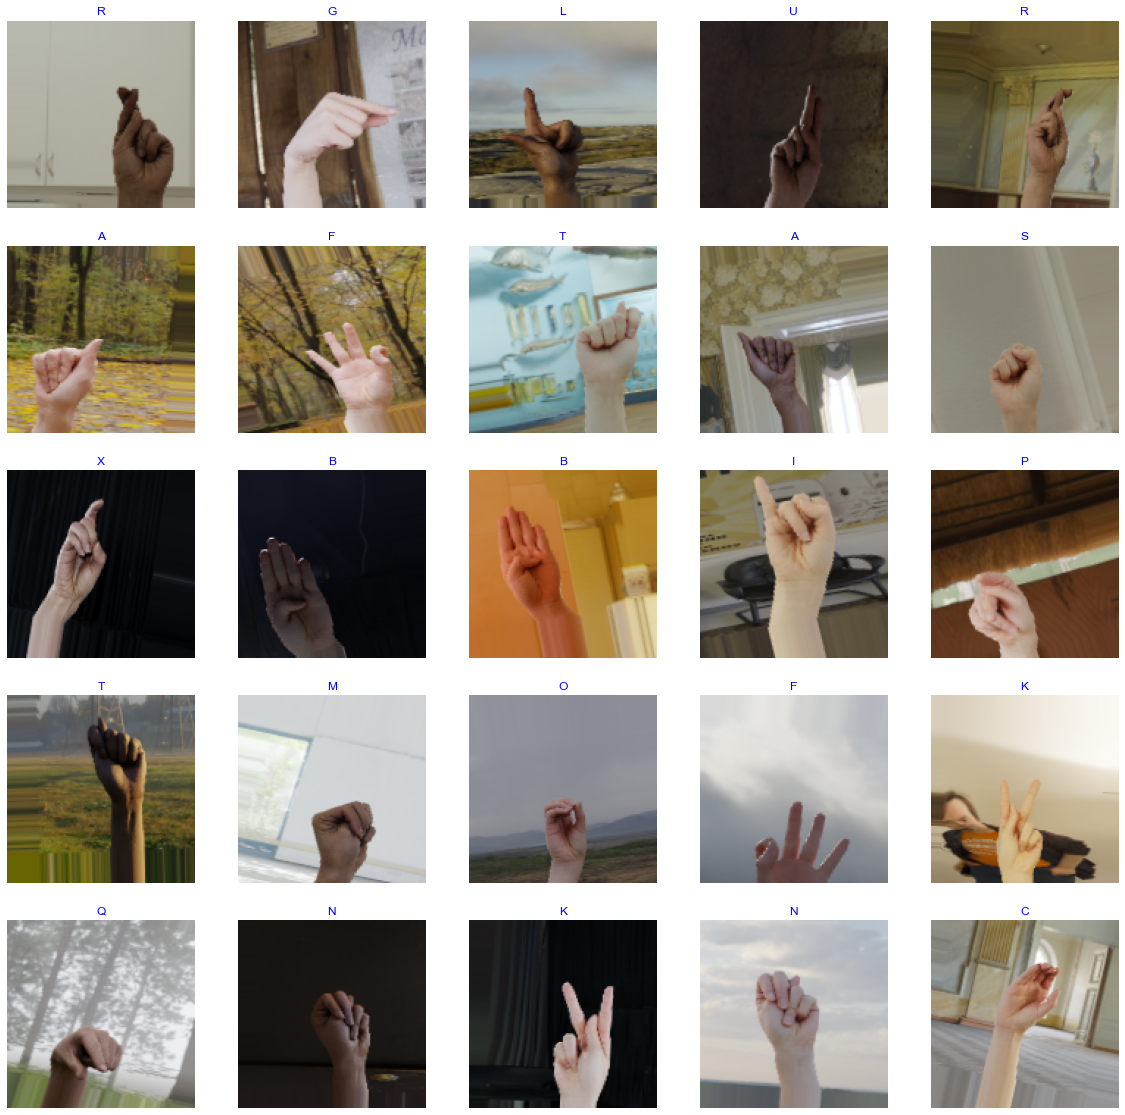

In [68]:
show_image_samples(train_gen)

In [84]:
a = next(valid_gen)

In [106]:
len(sorted(list(valid_df['labels'].unique())))

24

In [116]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [121]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(24, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0003), metrics = ['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 conv2d_38 (Conv2D)          (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 59, 59, 64)        18496     
                                                                 
 conv2d_40 (Conv2D)          (None, 57, 57, 64)        36928     
                                                      

In [122]:
history = model.fit(train_gen, batch_size = 128, epochs = 50, verbose = 1, validation_data=valid_gen)

Epoch 1/50
120/120 [==============================] - 826s 7s/step - loss: 3.3160 - acc: 0.0386 - val_loss: 3.1759 - val_acc: 0.0500
Epoch 2/50
120/120 [==============================] - 794s 7s/step - loss: 3.1797 - acc: 0.0411 - val_loss: 3.1759 - val_acc: 0.0417
Epoch 3/50
120/120 [==============================] - 778s 6s/step - loss: 3.1762 - acc: 0.0450 - val_loss: 3.1629 - val_acc: 0.0486
Epoch 4/50
120/120 [==============================] - 766s 6s/step - loss: 3.1737 - acc: 0.0514 - val_loss: 3.0950 - val_acc: 0.0903
Epoch 5/50
120/120 [==============================] - 766s 6s/step - loss: 3.1496 - acc: 0.0686 - val_loss: 3.0011 - val_acc: 0.1019
Epoch 6/50
120/120 [==============================] - 770s 6s/step - loss: 3.1123 - acc: 0.0714 - val_loss: 2.9052 - val_acc: 0.1088
Epoch 7/50
120/120 [==============================] - 776s 6s/step - loss: 3.0215 - acc: 0.1008 - val_loss: 2.8837 - val_acc: 0.1352
Epoch 8/50
120/120 [==============================] - 764s 6s/step - 

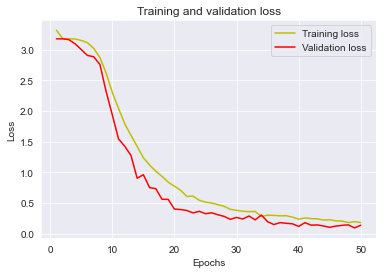

In [124]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

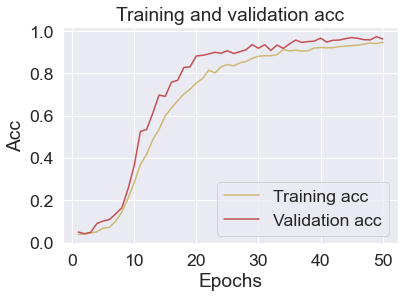

In [126]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

30/30 [==============================] - 108s 4s/step
there were 90 errors in 2400 tests for an accuracy of  96.25


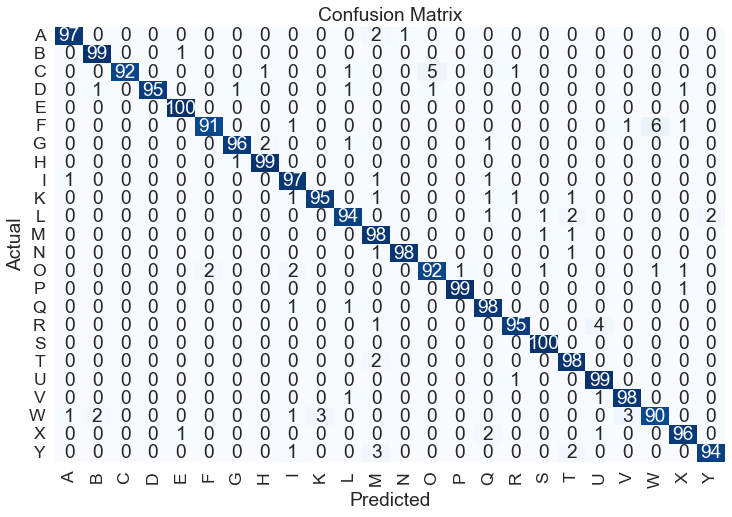

Classification Report:
----------------------
               precision    recall  f1-score   support

           A     0.9798    0.9700    0.9749       100
           B     0.9706    0.9900    0.9802       100
           C     1.0000    0.9200    0.9583       100
           D     1.0000    0.9500    0.9744       100
           E     0.9804    1.0000    0.9901       100
           F     0.9785    0.9100    0.9430       100
           G     0.9796    0.9600    0.9697       100
           H     0.9706    0.9900    0.9802       100
           I     0.9327    0.9700    0.9510       100
           K     0.9694    0.9500    0.9596       100
           L     0.9495    0.9400    0.9447       100
           M     0.8991    0.9800    0.9378       100
           N     0.9899    0.9800    0.9849       100
           O     0.9388    0.9200    0.9293       100
           P     0.9900    0.9900    0.9900       100
           Q     0.9423    0.9800    0.9608       100
           R     0.9694    0.9500 

In [170]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [171]:
subject = 'metoda0' 
acc = str(( 1-errors/tests) * 100)
index = acc.rfind('.')
acc = acc[:index + 3]
save_id = subject + '_' + str(acc) + '.h5' 
model_save_loc = os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  ./metoda0_96.25.h5
